# Investigating orientation parameters for eccentric waveforms

Importing Necessary packages

In [1]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
import matplotlib.pyplot as plt
import numpy as np
from pycbc.types import TimeSeries
from pycbc import conversions

In [2]:
from pycbc.psd import aLIGOZeroDetHighPower

In [3]:
from pycbc.filter import overlap_cplx, overlap

In [4]:
import EOBRun_module
import copy

In the notebook we look at varying phase, polarization, inclination and starting frequency.  Summary:
 - The two polarizations look as expected, out of phase by 90 degrees
 - Changing the phase of the binary does just that.  It doesn't impact the maxima/minima of the modulations from eccentricity
 - Changing the inclination impacts the overall amplitudes of the signal as expected
 - Changing the starting frequency impacts the location of the maxima/minima of the modulations.  It looks like TEOBresumS starts at a minimum, while EccentricTD starts at a max.  Note: changing the frequency between min/max/average doesn't change the fact that it starts at a minimum

Creating a sample eccentric waveform to be matched to

In [5]:
def TEOB(M, q, e, ecc_freq=1, f_low=15., phase=0., inclination=0., return_hc = False):
    pars = {
        # System parametes, assuming aligned spins        
        'M'                  : M,      # Total mass
        'q'                  : q,      # Mass ratio m1/m2 > 1
        'chi1'               : 0,      # Z component of chi_1
        'chi2'               : 0,      # Z component of chi_2
        'LambdaAl2'          : 0.,     # Quadrupolar tidal parameter of body 1 (A)
        'LambdaBl2'          : 0.,     # Quadrupolar tidal parameter of body 2 (B)
        'ecc'                : e,      # Eccentricity. Default = 0.
        'ecc_freq'           : ecc_freq, # Use periastron (0), average (1) or apastron (2) frequency for initial condition computation. Default = 1
        'coalescence_angle'  : phase,
        'inclination'        : inclination,

        # Initial conditions and output time grid
        'domain'             : 0,      # Time domain. EOBSPA is not available for eccentric waveforms!
        'srate_interp'       : 4096.,  # srate at which to interpolate. Default = 4096.
        'use_geometric_units': 0,   # output quantities in geometric units. Default = 1
        'initial_frequency'  : f_low,  # in Hz if use_geometric_units = 0, else in geometric units
        'interp_uniform_grid': 1,  # interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)

        # Modes
        'use_mode_lm'        : [1],    # List of modes to use/output through EOBRunPy

        # Output parameters (Python)
        'arg_out'            : 1,  # Output hlm/hflm. Default = 0
    }
    t, hp, hc, hlm, dyn = EOBRun_module.EOBRunPy(pars)
    h    = hp - 1j*hc
    tmrg = t[np.argmax(np.abs(h))]
    t    = t - tmrg # shift to mrg
    #Converting TEOB to a timeseries
    hp = TimeSeries(hp,delta_t=t[1]-t[0], epoch=t[0])
    if return_hc:
        hc = TimeSeries(hc,delta_t=t[1]-t[0], epoch=t[0])
        return hp,hc
    else:
        return hp

In [6]:
def trim_waveform(h_ref, hp, hc = None):
    r = len(h_ref) - len(hp)
    hp.roll(r)
    hp.resize(len(h_ref))
    hp.start_time = h_ref.start_time
    
    if hc:
        hc, _ = trim_waveform(h_ref, hc)

    return hp, hc

## Generate the reference waveform -- at periastron

Reference parameters

In [7]:
q = 2.
m = 60.
e = 0.2
f_low = 10.
phase = 0.
inc = 0.
tlen = 4096 * 16

In [8]:
hp_orig, hc_orig = TEOB(m, q, e, f_low=f_low, phase=phase, inclination=inc, return_hc=True)

In [9]:
hp = copy.deepcopy(hp_orig)
hp.resize(tlen)
hc = copy.deepcopy(hc_orig)
hc.resize(tlen)

In [10]:
# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / hp.duration
tlen = len(hp)
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

### Work out frequency shift for 1 eccentricity cycle

For now do a grid, but probably worth changing to an optimizer

In [11]:
dfs = np.linspace(0.05, 0.25, 41)
matches = np.zeros_like(dfs)
dts = np.zeros_like(dfs)

In [12]:
for i, df in enumerate(dfs):
    f = f_low - df
    hp_f = TEOB(m, q, e, f_low=f, phase=phase, inclination=inc, return_hc=False)
    hp_f, _ = trim_waveform(hp_orig, hp_f)
    hp_f.resize(tlen)
    matches[i], dts[i] = match(hp, hp_f, psd= psd, low_frequency_cutoff=20., subsample_interpolation=True)

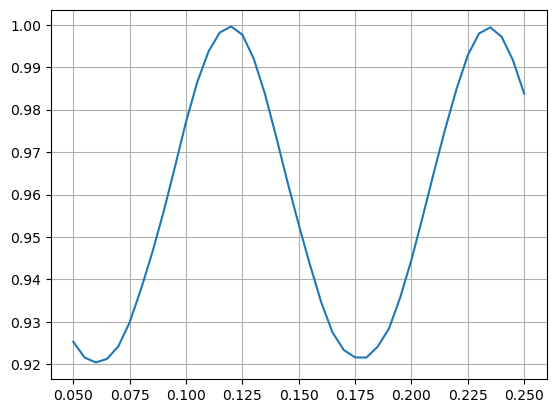

In [13]:
plt.plot(dfs, abs(matches))
plt.grid()

In [14]:
df = dfs[np.argmax(matches)]

In [15]:
df

0.12000000000000001

## Start half an eccentricity cycle out of phase -- at apastron

In [16]:
f_ap = f_low - df/2

In [17]:
hp_ap, hc_ap = TEOB(m, q, e, f_low=f_ap, phase=phase, inclination=inc, return_hc=True)
hp_ap, hc_ap = trim_waveform(hp_orig, hp_ap, hc_ap)
hp_ap.resize(tlen)
hc_ap.resize(tlen)

In [18]:
op = overlap_cplx(hp, hp_ap, psd=psd, low_frequency_cutoff=20.)
oc = overlap_cplx(hp, hc_ap, psd=psd, low_frequency_cutoff=20.)

Choose phase to give real overlap (waveforms in phase)

In [19]:
phi_ap = -np.angle(op)/2

In [20]:
hp_ap, hc_ap = TEOB(m, q, e, f_low=f_ap, phase=phi_ap, inclination=inc, return_hc=True)

In [21]:
hp_ap, hc_ap = trim_waveform(hp_orig, hp_ap, hc_ap)
hp_ap.resize(tlen)
hc_ap.resize(tlen)

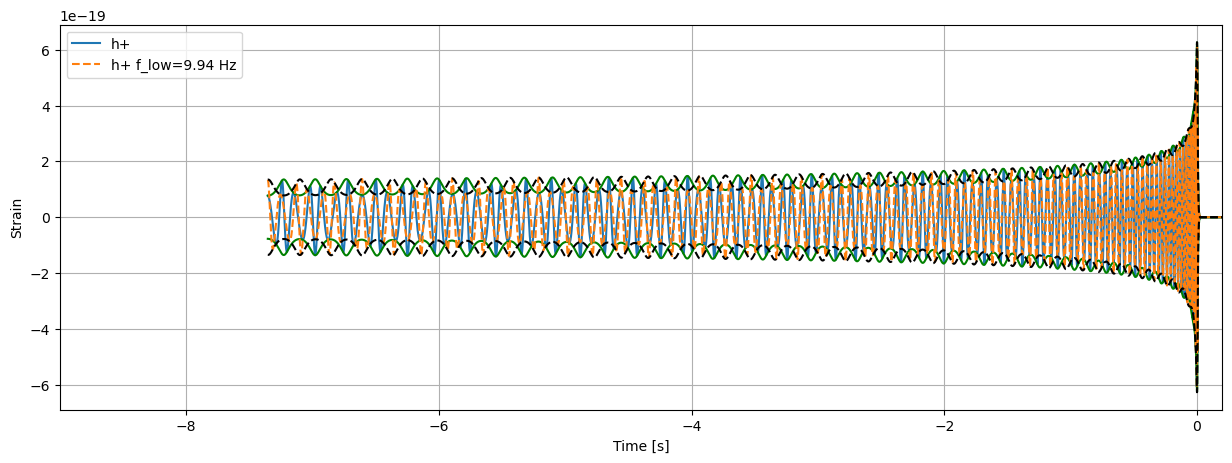

In [22]:
plt.figure(figsize=(15,5))
plt.plot(hp.sample_times, hp, label='h+')
#plt.plot(hc.sample_times, hc, label='hx')
plt.plot(hc.sample_times, np.sqrt(hp**2 + hc**2), color='g')
plt.plot(hc.sample_times, -np.sqrt(hp**2 + hc**2), color='g')

plt.plot(hp_ap.sample_times, hp_ap, '--', label='h+ f_low=%.2f Hz' % f_ap)
#plt.plot(hc_ap.sample_times, hc_ap, '--', label='hx f_low=%.2f Hz' % f5)
plt.plot(hc_ap.sample_times, np.sqrt(hp_ap**2 + hc_ap**2), '--', color='k')
plt.plot(hc_ap.sample_times, -np.sqrt(hp_ap**2 + hc_ap**2), '--', color='k')

plt.xlim(-9, 0.2)
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.grid()
plt.legend()

## Calculate sum and difference waveforms

In [23]:
hp_ave = (hp + hp_ap)/2
hp_dif = (hp - hp_ap)/2

hc_ave = (hc + hc_ap)/2
hc_dif = (hc - hc_ap)/2

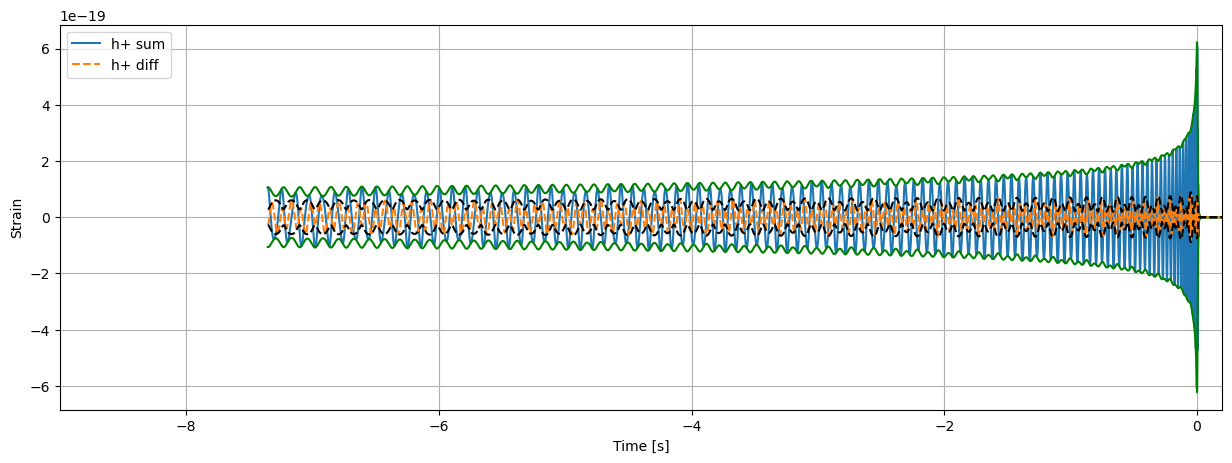

In [24]:
plt.figure(figsize=(15,5))
plt.plot(hp_ave.sample_times, hp_ave, label='h+ sum')
#plt.plot(hc_ave.sample_times, hc_ave, label='hx')
plt.plot(hp_ave.sample_times, np.sqrt(hp_ave**2 + hc_ave**2), color='g')
plt.plot(hc_ave.sample_times, -np.sqrt(hp_ave**2 + hc_ave**2), color='g')

plt.plot(hp_dif.sample_times, hp_dif, '--', label='h+ diff')
#plt.plot(hc_dif.sample_times, hc_ap, '--', label='hx f_low=%.2f Hz' % f5)
plt.plot(hc_dif.sample_times, np.sqrt(hp_dif**2 + hc_dif**2), '--', color='k')
plt.plot(hc_dif.sample_times, -np.sqrt(hp_dif**2 + hc_dif**2), '--', color='k')

plt.xlim(-9, 0.2)
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.grid()
plt.legend()

### Calculate overlaps

In [25]:
o = overlap_cplx(hp, hp_ap, psd=psd, low_frequency_cutoff=20.)
print('Overlap between periastron and apastron waveforms = %.3f, phase = %.1f deg' % (abs(o), np.degrees(np.angle(o)) ) )

Overlap between periastron and apastron waveforms = 0.909, phase = 0.0 deg


In [26]:
oa = overlap_cplx(hp, hp_ave, psd=psd, low_frequency_cutoff=20.)
print('Overlap between periastron and average waveform = %.3f, phase = %.1f deg' % (abs(oa), np.degrees(np.angle(oa)) ) )
od = overlap_cplx(hp, hp_dif, psd=psd, low_frequency_cutoff=20.)
print('Overlap between periastron and difference waveform = %.3f, phase = %.1f deg' % (abs(od), np.degrees(np.angle(od)) ) )
print('Quadrature sum of overlaps = %.3f' % np.sqrt(abs(od)**2 + abs(oa)**2) )

Overlap between periastron and average waveform = 0.977, phase = 0.0 deg
Overlap between periastron and difference waveform = 0.222, phase = -0.4 deg
Quadrature sum of overlaps = 1.002


In [27]:
oa = overlap_cplx(hp_ap, hp_ave, psd=psd, low_frequency_cutoff=20.)
print('Overlap between apastron and average waveform = %.3f, phase = %.1f deg' % (abs(oa), np.degrees(np.angle(oa)) ) )
od = overlap_cplx(hp_ap, hp_dif, psd=psd, low_frequency_cutoff=20.)
print('Overlap between apastron and difference waveform = %.3f, phase = %.1f deg' % (abs(od), np.degrees(np.angle(od)) ) )
print('Quadrature sum of overlaps = %.3f' % np.sqrt(abs(od)**2 + abs(oa)**2) )

Overlap between apastron and average waveform = 0.977, phase = -0.0 deg
Overlap between apastron and difference waveform = 0.205, phase = -179.6 deg
Quadrature sum of overlaps = 0.998


## An inbetween signal

In [28]:
f_mid = f_low - df/4

Choose phase to give real overlap (waveforms in phase)

In [29]:
phi_mid = np.angle(op)/4

In [30]:
hp_mid, hc_mid = TEOB(m, q, e, f_low=f_mid, phase=phi_mid, inclination=inc, return_hc=True)
hp_mid, hc_mid = trim_waveform(hp_orig, hp_mid, hc_mid)
hp_mid.resize(tlen)
hc_mid.resize(tlen)

In [31]:
op = overlap_cplx(hp, hp_mid, psd=psd, low_frequency_cutoff=20.)
oc = overlap_cplx(hp, hc_mid, psd=psd, low_frequency_cutoff=20.)

In [32]:
hp_mid, hc_mid = TEOB(m, q, e, f_low=f_mid, phase=phi_mid, inclination=inc, return_hc=True)

In [33]:
hp_mid, hc_mid = trim_waveform(hp_orig, hp_mid, hc_mid)
hp_mid.resize(tlen)
hc_mid.resize(tlen)

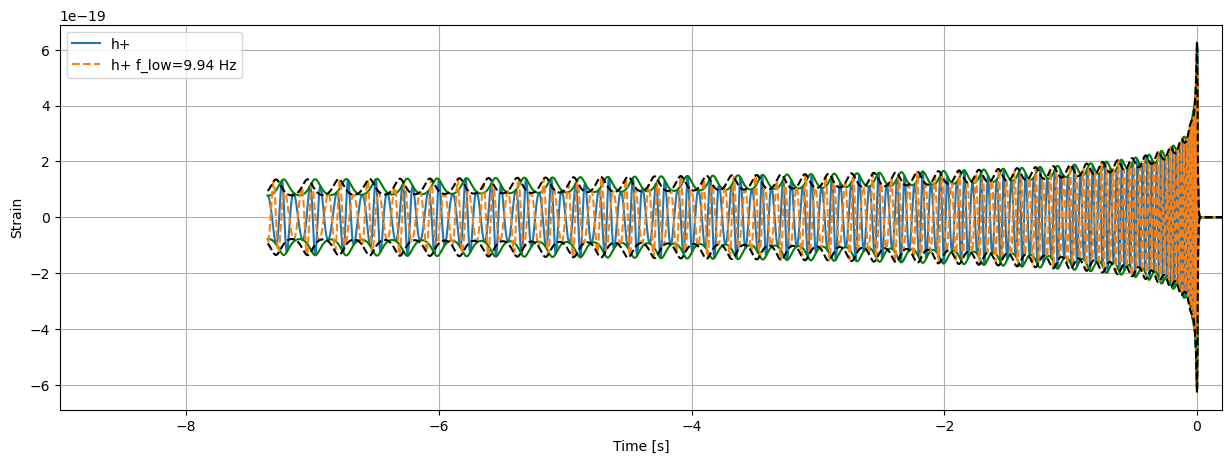

In [34]:
plt.figure(figsize=(15,5))
plt.plot(hp.sample_times, hp, label='h+')
#plt.plot(hc.sample_times, hc, label='hx')
plt.plot(hc.sample_times, np.sqrt(hp**2 + hc**2), color='g')
plt.plot(hc.sample_times, -np.sqrt(hp**2 + hc**2), color='g')

plt.plot(hp_mid.sample_times, hp_mid, '--', label='h+ f_low=%.2f Hz' % f_ap)
#plt.plot(hc_ap.sample_times, hc_ap, '--', label='hx f_low=%.2f Hz' % f5)
plt.plot(hc_mid.sample_times, np.sqrt(hp_mid**2 + hc_mid**2), '--', color='k')
plt.plot(hc_mid.sample_times, -np.sqrt(hp_mid**2 + hc_mid**2), '--', color='k')

plt.xlim(-9,0.2)
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.grid()
plt.legend()

In [35]:
o = overlap_cplx(hp_mid, hp, psd=psd, low_frequency_cutoff=20.)
print('Overlap between mid and periastron waveform = %.3f, phase = %.1f deg' % (abs(o), np.degrees(np.angle(o)) ) )
oa = overlap_cplx(hp_mid, hp_ave, psd=psd, low_frequency_cutoff=20.)
print('Overlap between mid and average waveform = %.3f, phase = %.1f deg' % (abs(oa), np.degrees(np.angle(oa)) ) )
od = overlap_cplx(hp_mid, hp_dif, psd=psd, low_frequency_cutoff=20.)
print('Overlap between mid and difference waveform = %.3f, phase = %.1f deg' % (abs(od), np.degrees(np.angle(od)) ) )
print('Quadrature sum of overlaps = %.3f' % np.sqrt(abs(od)**2 + abs(oa)**2) )

Overlap between mid and periastron waveform = 0.954, phase = 118.2 deg
Overlap between mid and average waveform = 0.969, phase = 120.4 deg
Overlap between mid and difference waveform = 0.177, phase = 42.7 deg
Quadrature sum of overlaps = 0.985
